In [ ]:
import numpy as np
import sys
import os
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
np.set_printoptions(threshold=sys.maxsize) # show full ndarray

# Prior

In [2]:
## Prior Generation 
# The script Open3D Simulation/PriorSimulation.py will simulate the prior
# Each prior is a 512 x 512 numpy matrix (corresponding to 512 x 512 pixel image) 
# Each prior simulates the degree of occlusion of human vision in random situations

# the 1000 times simulation will produce 1000 numpy matrix in '../Snapshots/Snapshots-new-200/'

# the prior is generated by a simple pinhole camera model implemented in open3D with 
# - focal length 256
# - 200 surfaces sized from 0.2m to 18m
# - x-coord is postioned at the center, and y-coord is positioned between 1.65m (human height offset) and 25m
# - the surfaces are distanced between 2.5m and 300m

## Prior preprocessing
# We combine the 1000 prior into a 512 x 512 x 1000 matrix 
# and store it into two versions:
# 1. a generic one, containing the prior for all visual angles
# 2. a middle prior, containing the prior with visual angles only vary vertically. 
#    This is the middle slice of the generic one. We find the median among 1000 prior to avoid the issue of outlier.
 
# read into the generic version of the prior
def combine_prior(suffix):
    directory = '../Snapshots/Snapshots-'+suffix+'/'
    prior = np.empty([512, 512])
    initialise = True
    
    # iterate over each prior snapshot
    for filename in os.listdir(directory):
        if filename == '.DS_Store': # for MAC
            continue
        snapshot = np.load(directory + filename)
        if initialise is True:
            prior = snapshot
            initialise = False
        else:
            prior = np.dstack((prior, snapshot))  
    prior = np.ma.masked_invalid(prior) # ignore inf depths where the pixels are not occcluded
    return prior

# find the median for each pixel
def find_median(prior):
    for iy, ix in np.ndindex(prior.shape[:2]):
        prior_median = np.empty([512, 512]) # TODO image size 
        prior_median[iy][ix] = np.median(prior[iy][ix][prior[iy][ix] <= 300]) # ignore distance > 300, take the median to avoid outliers
    return prior_median

def read_prior(suffix):
    prior = combine_prior(suffix) # f = 256, 200 surfaces simulated at x = 256
    prior_median = find_median(prior)
    return prior_median, prior # middle prior, generic prior

In [ ]:
# # the function read_prior is to produce the prior and prior_median, which can be directly read from the text files.
# # prior_median, prior = read_prior('new-200') 

# np.savetxt('prior_median.txt', prior_median)
# prior_median = np.loadtxt('prior_median.txt')

# # to store the 3D array
# prior_reshaped = prior.reshape(prior.shape[0], -1)
# np.savetxt('prior.txt', prior_reshaped)
# prior_reshaped = prior = np.loadtxt('prior.txt')
# prior = prior_reshaped.reshape(prior_reshaped.shape[0], prior_reshaped.shape[1] // 512, 512)

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/var/folders/2h/6xl9zzd51h753mb206k2zn4r0000gn/T/ipykernel_75393/3748264543.py:44: UserWarning: Warning: converting a masked element to nan.
  prior_median[iy][ix] = np.median(prior[iy][ix][prior[iy][ix] <= 300]) # ignore distance > 300, take the median to avoid outliers


<AxesSubplot:xlabel='Distance', ylabel='Height'>

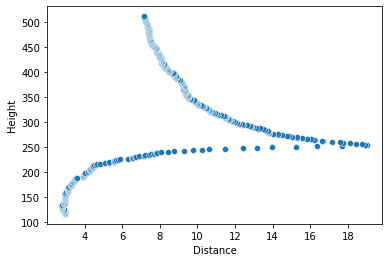

In [3]:
prior_median, prior = read_prior('new-200') # it takes around 5mins.

height = np.array(range(512))
prior_median_dist = np.append(height[:, None], prior_median[:, 255][:, None], axis=1)
column_values = ['Height', 'Distance']
prior_median_dist_df = pd.DataFrame(data = prior_median_dist, columns = column_values)
sns.scatterplot(data = prior_median_dist_df, x="Distance", y="Height")

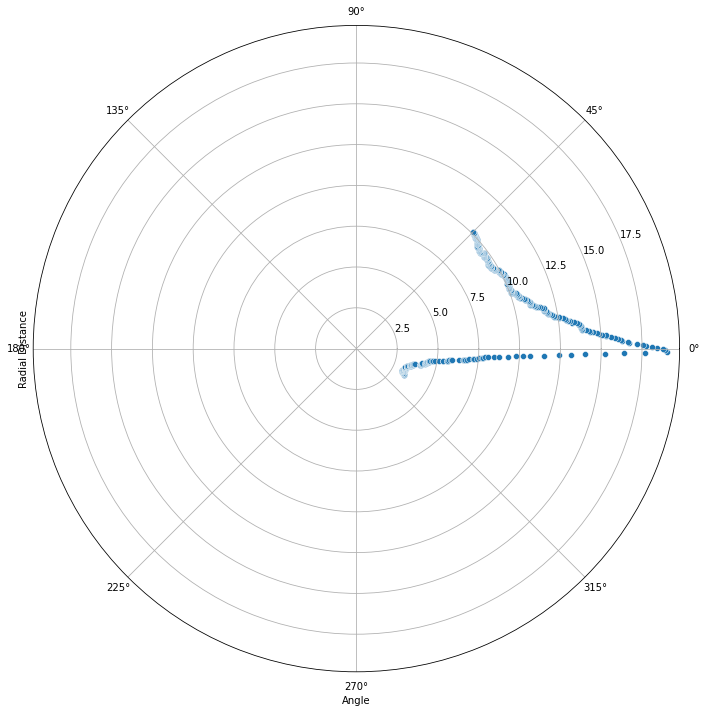

In [6]:
# plot the prior in polar coordinates
prior_middle = prior[:, 255, :]

F = 256 # focal_length
offset = 256
prior_median_dist_df["TransformedHeight"] = prior_median_dist_df["Height"] - offset # offset to 0
prior_median_dist_df["Angle"] = np.arctan((prior_median_dist_df["TransformedHeight"] + 0.5) / F)
prior_median_dist_df["Radial Distance"] = prior_median_dist_df["Distance"] / np.cos(prior_median_dist_df["Angle"])

prior_median_dist_df.to_pickle('prior_median_dist_new-200')
g = sns.FacetGrid(prior_median_dist_df, subplot_kws=dict(projection='polar'), height=10, despine=False)
g.map_dataframe(sns.scatterplot, x='Angle', y='Radial Distance')
plt.show()

In [27]:
# Store the Prior Locally
prior_middle = prior[:, 255, :]

np.savez_compressed('prior.npz', data=prior.data, mask=prior.mask)
np.savez_compressed('prior_middle.npz', data=prior_middle.data, mask=prior_middle.mask)
np.savez_compressed('prior_median.npz', data=prior_median)

# prior_tensor = torch.from_numpy(prior)
# torch.save(prior_tensor, 'prior_tensor.pt')

# prior_middle_tensor = torch.from_numpy(prior_middle)
# torch.save(prior_middle_tensor, 'prior_middle_tensor.pt')

# # prior_median_tf = tf.convert_to_tensor(prior_median)
# prior_median_tensor = torch.from_numpy(prior_median)
# torch.save(prior_middle_tensor, 'prior_median_tensor.pt')

**Sanity Check: Distance Distribution**

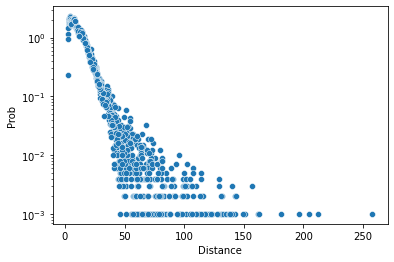

In [11]:

for iy, ix in np.ndindex(prior_middle.shape):
    prior_middle[iy][ix] = prior_middle[iy][ix] / np.cos(np.arctan((iy - F + 0.5)/F))
    
elements_count = {}
# find the probability of each visible distance
for iy, ix in np.ndindex(prior_middle.shape):
    element = prior_middle[iy][ix]
    if not np.ma.is_masked(element):
        element = round(element, 1)
        if element in elements_count:
            elements_count[element] += 1
        else:
            elements_count[element] = 1
            
prob = np.array(list(elements_count.values())) / 1000
distance = np.array(list(elements_count.keys()))

distance_dist = np.append(prob[:, None], distance[:, None], axis=1)
column_values = ['Prob', 'Distance']
distance_dist_df = pd.DataFrame(data = distance_dist, columns = column_values)
sns.scatterplot(data = distance_dist_df, x="Distance", y="Prob")
plt.yscale('log')